# Train Face Emotion Classifier

## Import Packages and define Learning

In [2]:
from __future__ import division, absolute_import

from dataset_loader import DatasetLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


from constants import *
from os.path import isfile, join
from os import makedirs
from time import strftime, localtime
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import sys

## Prepare Training and Test Set

In [21]:
images = np.load(join('data', 'data_images.npy'))
images = images.reshape([-1, SIZE_FACE, SIZE_FACE, 1])
labels = np.load(join('data', 'data_labels.npy')).reshape([-1, len(EMOTIONS)])

print('COMPLETE DATA SET: images.shape:',images.shape,'labels.shape:',labels.shape)
train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.20, random_state=42)
print('TRAINING DATA SET: images.shape:',train_x.shape,'labels.shape:',train_y.shape)
print('TESTIMG DATA SET: images.shape:',test_x.shape,'labels.shape:',test_y.shape)

COMPLETE DATA SET: images.shape: (14018, 48, 48, 1) labels.shape: (14018, 7)
TRAINING DATA SET: images.shape: (11214, 48, 48, 1) labels.shape: (11214, 7)
TESTIMG DATA SET: images.shape: (2804, 48, 48, 1) labels.shape: (2804, 7)


### Make Dummy Classification

In [22]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X=train_x, y=train_y)
dummy.score(X=test_x, y=test_y)

0.08238231098430814

### Define Log Directory
Start here to set a fresh log directory with.

In [23]:
log_path = './logs/' + strftime('%Y-%m-%d-%H-%M',localtime())
model_name = 'EmotionClassifier-EP{epoch:02d}-ACC{val_categorical_accuracy:.2f}.hdf5' 

makedirs(log_path, exist_ok=False)

### Define Keras Callbacks

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1, verbose=1,
                              patience=5, min_lr=1e-6)

model_check_point = ModelCheckpoint(join(log_path,model_name), 
                                  monitor='val_categorical_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='max')

callbacks = [reduce_lr, model_check_point]

In [25]:
# No rescale, because already done!!

image_data_gen_args = dict(#featurewise_center=False,
                           #featurewise_std_normalization=False,
                           rotation_range=30,
                           width_shift_range=0.3,
                           height_shift_range=0.3,
                           horizontal_flip=False,
                           zoom_range=0.3
                          )

datagen = ImageDataGenerator(image_data_gen_args)
#datagen.fit(x=train_x)

## Model Definition

In [26]:
INPUT_SHAPE = [SIZE_FACE,SIZE_FACE,1]
OUTPUT_SHAPE = len(EMOTIONS)


vgg_like = Sequential([
    #InputLayer(input_shape =(SIZE_FACE, SIZE_FACE, 1),name='input'),
    Conv2D(filters=32,kernel_size=(3,3),input_shape=INPUT_SHAPE, padding='valid', activation='relu'),
    Conv2D(filters=32,kernel_size=(3,3), padding='valid', activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2, padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=2, padding='same'),
    #BatchNormalization(),
    Conv2D(filters=128,kernel_size=(3,3), activation='relu', padding='valid'),
    Conv2D(filters=128,kernel_size=(3,3), activation='relu',strides=2, padding='valid'),    
    #Conv2D(filters=128,kernel_size=(3,3), activation='relu', strides=2, padding='valid'),
    #MaxPool2D(pool_size=(3, 3), strides=2, padding='same'),
    Flatten(),
    Dropout(0.5),
    Dense(units=512,activation='relu'),
    Dense(units=OUTPUT_SHAPE, activation='softmax')
])



model = Sequential([Conv2D(filters=32,kernel_size=(3,3),input_shape=INPUT_SHAPE, activation='relu'),
                    MaxPool2D(pool_size=(3, 3), strides=2),
                    Conv2D(filters=32,kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(3, 3), strides=2),
                    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(3, 3), strides=2),
                    Conv2D(filters=128,kernel_size=(3,3), activation='relu', strides=2, padding='same'),
                    Flatten(),
                    Dropout(0.5),
                    Dense(units=512,activation='relu'),
                    Dense(units=OUTPUT_SHAPE, activation='softmax')])

model = vgg_like

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

# Save Generator Parameter and Model Summery in .txt file

with open(join(log_path,'model_summery.txt'),'w+') as fh:
    fh.write(str('ImageDataGenerator\n'))
    fh.write(str('==================\n'))
    fh.write(str(image_data_gen_args))
    fh.write('\n\n\n\n')
    # Pass the file handle in as a lambda function to make it callable
    fh.write(str('Model Summery\n'))
    fh.write(str('=============\n'))
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 22, 22, 64)        36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 22, 22, 64)        36928     
__________

## Start Training

In [27]:
BATCH_SIZE = 128
EPOCH = 50

history = model.fit_generator(
    generator=datagen.flow(x=train_x,y=train_y,batch_size=BATCH_SIZE),
    steps_per_epoch=2*(len(train_x)/BATCH_SIZE),
    epochs=EPOCH,
    #validation_data=test_datagen.flow(x=test_x,y=test_y,batch_size=BATCH_SIZE),
    validation_data=(test_x,test_y),
    #validation_steps=len(test_x)/BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50
2804/2804 [==============================] - 1s 199us/sample - loss: 1.8851 - categorical_accuracy: 0.3516

Epoch 00001: val_categorical_accuracy improved from -inf to 0.35164, saving model to ./logs/2019-04-04-08-51/EmotionClassifier-EP01-ACC0.35.hdf5
88/88 [==============================] - 5s 59ms/step - loss: 1.7465 - categorical_accuracy: 0.3281 - val_loss: 1.8851 - val_categorical_accuracy: 0.3516
Epoch 2/50
2804/2804 [==============================] - 0s 63us/sample - loss: 1.8030 - categorical_accuracy: 0.4793

Epoch 00002: val_categorical_accuracy improved from 0.35164 to 0.47932, saving model to ./logs/2019-04-04-08-51/EmotionClassifier-EP02-ACC0.48.hdf5
88/88 [==============================] - 2s 21ms/step - loss: 1.4689 - categorical_accuracy: 0.4669 - val_loss: 1.8030 - val_categorical_accuracy: 0.4793
Epoch 3/50
2804/2804 [==============================] - 0s 55us/sample - loss: 1.6550 - categorical_accuracy: 0.5310

Epoch 00003: val_categorical_accuracy improv

## Modell Validation

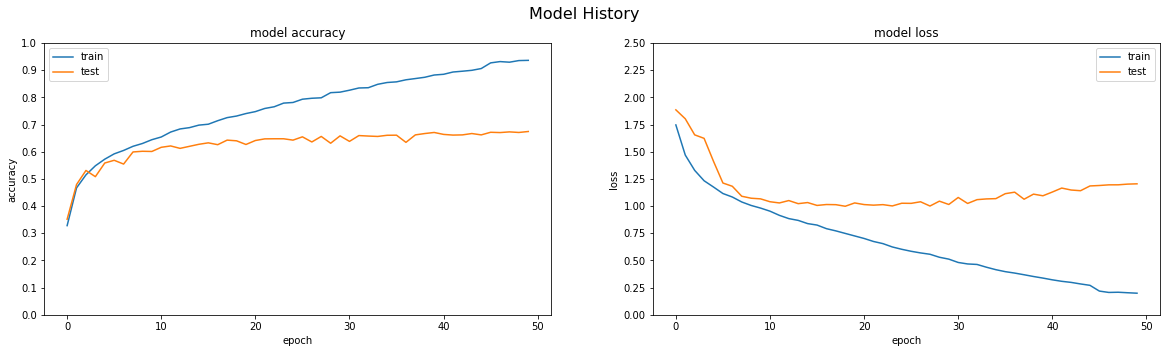

In [28]:
fig = plt.figure(figsize=(20,5))
fig.suptitle('Model History',fontsize=16)

# summarize history for loss
ax = fig.add_subplot(121)
ax.plot(history.history['categorical_accuracy'])
ax.plot(history.history['val_categorical_accuracy'])
# summarize history for accuracy
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_yticks(np.arange(0,1.1,step=.1))
ax.set_xlabel('epoch')
ax.legend(['train', 'test'])#, loc='upper left')

# summarize history for loss
ax = fig.add_subplot(122)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_yticks(np.arange(0,2.6,step=.25))
ax.set_xlabel('epoch')
ax.legend(['train', 'test'])#, loc='upper left')
plt.savefig(join(log_path,'model_history.png'), format='png')
plt.show()

## Confusion Matrix

In [5]:
top_acc_model = load_model(filepath='./logs/2019-03-11-10-11/EmotionClassifier-EP35-ACC0.68.hdf5')
current_model = load_model(filepath='./data/emotion_recognition_model.hdf5')

print(current_model.evaluate(x=test_x, y=test_y))
print(top_acc_model.evaluate(x=test_x, y=test_y))

2804/2804 [==============================] - 0s 139us/step
[1.064033034694688, 0.61269614835948649]
2804/2804 [==============================] - 0s 169us/step
[1.281970519312098, 0.67546362331012177]


In [10]:
prediction = current_model.predict(x=test_x)
prediction = np.argmax(prediction,axis=1)
true_class = np.argmax(test_y, axis=1)
print(prediction)
print(true_class)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=true_class,y_pred=prediction)


[3 5 6 ..., 6 4 6]
[3 5 6 ..., 6 4 6]


array([[140,   1,  21,  21,  49,  12,  79],
       [ 20,  10,   1,   5,   7,   2,   8],
       [ 57,   2,  84,  36,  53,  57,  83],
       [ 10,   0,  15, 698,  12,  22,  60],
       [ 30,   1,  19,  34, 120,   7, 138],
       [ 11,   0,  12,  23,   6, 230,  28],
       [ 21,   0,  10,  57,  48,   8, 436]])

In [7]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    ulist = unique_labels(y_true, y_pred)
    #print(classes[ulist])
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

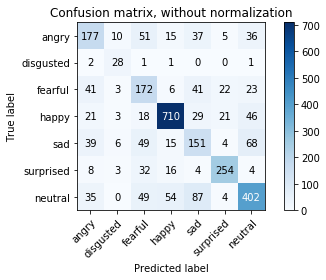

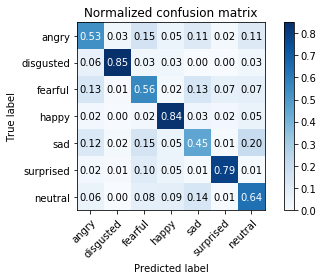

In [9]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(prediction, true_class, classes=EMOTIONS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(prediction, true_class, classes=EMOTIONS, normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig(join(log_path,'confusion_matrix.png'), format='png')
plt.show()

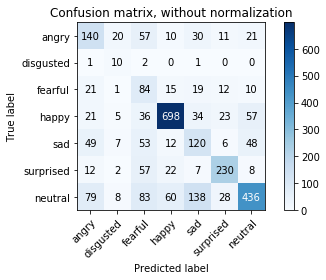

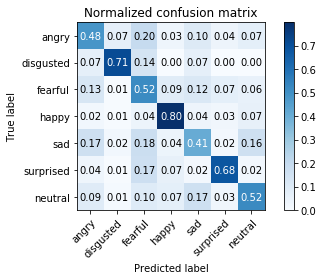

In [11]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(prediction, true_class, classes=EMOTIONS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(prediction, true_class, classes=EMOTIONS, normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig(join(log_path,'confusion_matrix.png'), format='png')
plt.show()